## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


### Dataset

In this homework, we will use the Students Performance in 2024 JAMB dataset from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb).

Here's a wget-able [link](https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv):

```bash
wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
```

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column `'JAMB_Score'`).



In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

In [2]:
df = pd.read_csv('https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv')
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1



### Preparing the dataset 

First, let's make the names lowercase:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Preparation:

* Remove the `student_id` column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head(1)

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2


In [4]:
del df["student_id"]
df = df.fillna(0)

In [5]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [6]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

In [7]:
del df_train["jamb_score"]
del df_val["jamb_score"]
del df_test["jamb_score"]

In [8]:
train_dicts = df_train.to_dict(orient = "records")
dv = DictVectorizer(sparse = True)
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val.to_dict(orient = "records")
X_val = dv.transform(val_dicts)




## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* **`study_hours_per_week`**
* `attendance_rate`
* `teacher_quality`
* `distance_to_school`

In [9]:
dt = DecisionTreeRegressor(max_depth = 1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:
print(export_text(dt, feature_names = dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]






## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 22.13
* **42.13**
* 62.13
* 82.12



In [11]:
rf = RandomForestRegressor(n_estimators=10,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("RMSE :", round(root_mean_squared_error(y_val, y_pred), 2))

RMSE : 42.14



## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- **80**
- 200



In [12]:
scores = []

for n in range(10, 201, 5):
    rf = RandomForestRegressor(n_estimators=n,
                           random_state=1,
                           n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    scores.append((n, rmse))

In [13]:
df_scores = pd.DataFrame(scores, columns=["n_estimators", "rmse"])
df_scores.round(3)

,n_estimators,rmse
0,10,42.137
1,15,41.865
2,20,41.461
3,25,41.253
4,30,41.106
5,35,41.011
6,40,40.917
7,45,40.947
8,50,40.852
9,55,40.819


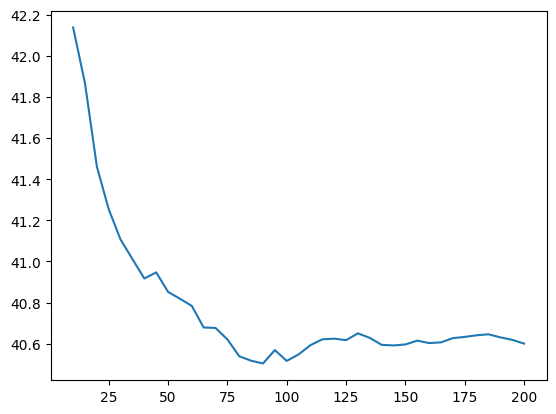

In [14]:
plt.plot(df_scores.n_estimators, df_scores.rmse)


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* **10**
* 15
* 20
* 25



In [17]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=d,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        scores.append((d, n, rmse))

In [18]:
df_scores = pd.DataFrame(scores, columns=["max_depth", "n_estimators", "rmse"])
df_scores.head()

,max_depth,n_estimators,rmse
0,10,10,41.258349
1,10,20,40.880528
2,10,30,40.624956
3,10,40,40.270069
4,10,50,40.317006


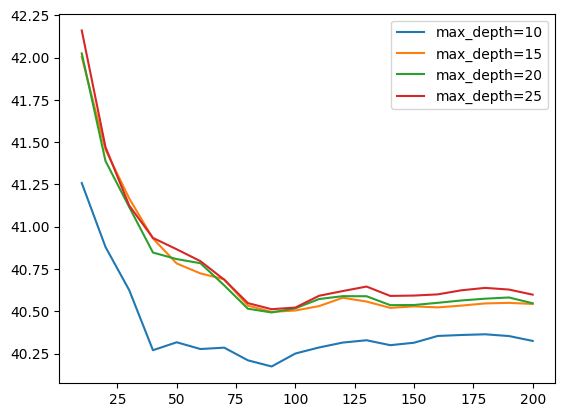

In [22]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)

plt.legend()
    


# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* **`study_hours_per_week`**
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`

In [23]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
       0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
       0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
       0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
       0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
       0.01070798, 0.01056268, 0.24835361, 0.08268222])

In [25]:
df_importances = pd.DataFrame()
df_importances["feature"] = dv.feature_names_
df_importances["importance"] = rf.feature_importances_
df_importances.sort_values(by="importance", ascending = False).head()

,feature,importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311





## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value


In [34]:
features = dv.feature_names_
features

['access_to_learning_materials=No',
 'access_to_learning_materials=Yes',
 'age',
 'assignments_completed',
 'attendance_rate',
 'distance_to_school',
 'extra_tutorials=No',
 'extra_tutorials=Yes',
 'gender=Female',
 'gender=Male',
 'it_knowledge=High',
 'it_knowledge=Low',
 'it_knowledge=Medium',
 'parent_education_level',
 'parent_education_level=Primary',
 'parent_education_level=Secondary',
 'parent_education_level=Tertiary',
 'parent_involvement=High',
 'parent_involvement=Low',
 'parent_involvement=Medium',
 'school_location=Rural',
 'school_location=Urban',
 'school_type=Private',
 'school_type=Public',
 'socioeconomic_status=High',
 'socioeconomic_status=Low',
 'socioeconomic_status=Medium',
 'study_hours_per_week',
 'teacher_quality']

In [35]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [36]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round = 100,
                 evals=watchlist)


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw06
* If your answer doesn't match options exactly, select the closest one